<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%9E%D1%87%D0%B8%D1%89%D0%B0%D0%B5%D0%BC_%D0%B4%D0%BE%D0%BA%D1%83%D0%BC%D0%B5%D0%BD%D1%82%D1%8B_%D0%BE%D1%82_%D0%BD%D0%B5%D0%BD%D1%83%D0%B6%D0%BD%D0%BE%D0%B3%D0%BE_%D1%88%D1%83%D0%BC%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Очищаем документы от ненужного шума

# Cleaning up documents from unnecessary noise

В данном уроке мы будем очищать загрязненное изображение от кучи ненужного мусора и шума, чтобы в  дальнейшем можно было спокойно работать с текстом.


In this tutorial we will clean the dirty image of a pile of unnecessary debris and noise so that we can work with the text in peace in the future.

Делать мы это будем по принципу изображения ниже: 

We will do it according to the image below: 

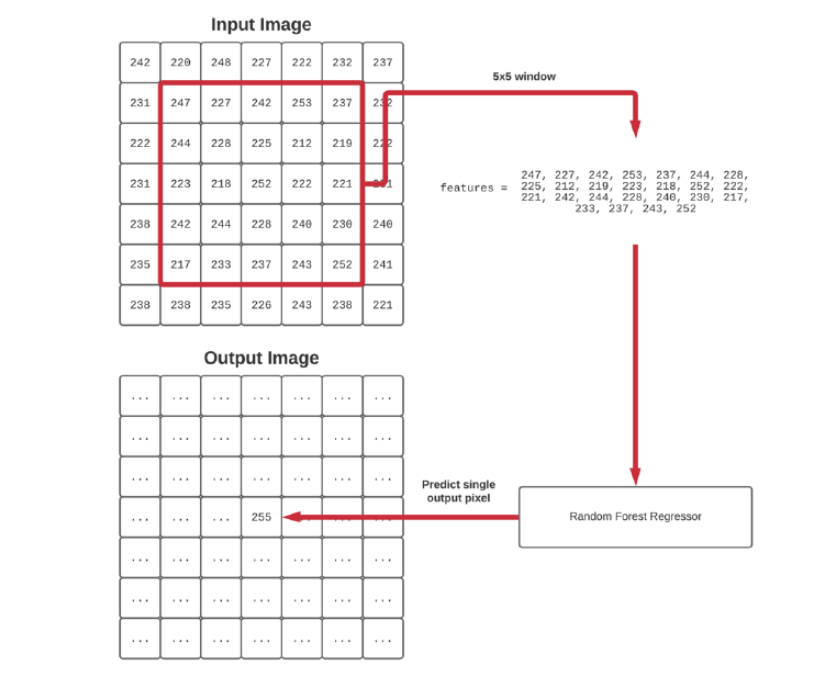

На основе сверточных нейронных сетей мы перемещаем окно размером 5х5, которое скользит  по пикселю за раз слева направо и сверху вниз. Сглаживаем  его в один вектор размера 25 (это будет наш вектор признаков). Именно этот вектор передается в нашу модель в качестве входа и предсказывается значение центрального (очищенного) пикселя.

В качетсве модели мы используем **random forest regressor (RFR)**. 




We use **random forest regressor (RFR)** as a model. 



# Структура проекта 

# Project structure 


`denoising-dirty-documents` - каталог, где хранятся все изображения. Внутри него расположены еще 3 каталога: 

The `denoising-dirty-documents` directory is where all the images are stored. Inside it are 3 more directories: 

- `train` - данные, на которых мы будем обучаться. the data on which we will train.
- `train_cleaned` - очищенные тренировочные данные. cleaned training data .
- `test`- данные, на которых мы будем предсказывать результаты на основе обученной сети. data on which we will predict results based on the trained network.

В файле `denoiser.pickle` будет храниться модель

The file `denoiser.py` will store the model

Остальные `.py` файлы вам пригодятся для локального запуска 









The other `.py` files you will need to run locally 

# Код

# Code


In [1]:
# установим и распакуем архив
# install and unpack the archive
!wget http://dataudt.ru/datasets/cv/Lesson_07.Denoise_document.zip
!unzip -qq Lesson_07.Denoise_document.zip
%cd Denoise_document

--2022-02-13 08:33:54--  http://dataudt.ru/datasets/cv/Lesson_07.Denoise_document.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89193940 (85M) [application/zip]
Saving to: ‘Lesson_07.Denoise_document.zip’

Lesson_07.Denoise_d 100%[===================>]  85.06M  21.9MB/s    in 4.3s    

2022-02-13 08:33:59 (19.7 MB/s) - ‘Lesson_07.Denoise_document.zip’ saved [89193940/89193940]

/content/Denoise_document


Первым делом рассмотрим конфигурационные файлы. 

The first thing to look at are the configuration files. 


In [2]:
# импортируйте необходимые пакеты
# import the necessary packages
import os

# указываем основной путь к набору данных входных документов
# initialize the base path to the input documents dataset
BASE_PATH = "/content/Denoise_document/dataset"

# определяем путь к обучающим каталогам
# define the path to the training directories
TRAIN_PATH = os.path.sep.join([BASE_PATH, "train"])
CLEANED_PATH = os.path.sep.join([BASE_PATH, "clean_train"])

# вероятность выборки для данной строки
# определяем путь к CSV-файлу наших выходных функций, затем инициализируем
# the sampling probability for a given row
# define the path to our output features CSV file then initialize



FEATURES_PATH = "features.csv" # указываем путь, куда будут записываться выходные данные 
                               # specify the path where the output data will be written to 
SAMPLE_PROB = 0.02 # будем записывать на диск только с данной вероятностью выборки  
                   # will only write to disk with a given sampling probability  


# путь, где находится наша обучающая модель 
# define the path to our document denoiser model
MODEL_PATH = "denoiser.pickle"

Напишем функцию, которая поможет нам предварительно обработать изображения. Ее цель размыть картинку, а затем вычесть ее из входного изображения, тем самым выделяя передний план, так как размытие убирает смазанные объекты и выявляет больше “структурных” компонентов изображения.


Let's write a function that helps us pre-process the image. Its purpose is to blur the image and then subtract it from the input image, thereby highlighting the foreground, since blurring removes blurred objects and reveals more of the "structural" components of the image.

Функция `blur_and_threshold` в качестве аргументов принимает изображение и эпсилон, который необходим для предотвращения деления на ноль.

The `blur_and_threshold` function takes an image and an epsilon as arguments, which is necessary to prevent division by zero.

In [3]:
# импорт необходимых библиотек
# import the necessary packages
import numpy as np
import cv2

def blur_and_threshold(image, eps=1e-7):
    # применяем к изображению срединное размытие и вычитаем его из оригинального изображения.  
    # Так мы приблизимся к переднему плану  
    # apply a median blur to the image and then subtract the blurred
    # image from the original image to approximate the foreground
    blur = cv2.medianBlur(image, 5)
    foreground = image.astype("float") - blur

    # указываем пороговое значение изображения переднего плана, установив
    # любые пиксели со значением больше нуля на ноль
    # threshold the foreground image by setting any pixels with a
    # value greater than zero to zero

    foreground[foreground > 0] = 0

    # применяем  максимальное и минимальное масштабирование, чтобы
    # довести интенсивность пикселей до диапазона [0, 1]
    # apply min/max scaling to bring the pixel intensities to the
    # range [0, 1]
    minVal = np.min(foreground)
    maxVal = np.max(foreground)
    foreground = (foreground - minVal) / (maxVal - minVal + eps)

    # возвращаем измененное изображение
    # return the foreground-approximated image
    return foreground

## Извлечение объектов для обучения модели 

## Extract objects for model training 


В этой часте мы преобразуем наши входные данные так, что бы сформировались матрицы размера 5х5 из зашумленного изображения, и извлеклись целевые пиксели из очищенных данных (пиксель, который мы будем предсказывать на основе зашумленного вектора)

In this part we will transform our input data so that a 5x5 matrix is formed from the noisy image, and the target pixels are extracted from the cleaned data (the pixel that we will predict based on the noisy vector)


В результате мы получим файл `features.csv` , который будет нашей обучающей выборкой 





As a result, we will get a file `features.csv` which will be our training sample 



In [4]:
# импорт необходимых библиотек
# import the necessary packages
from imutils import paths
import progressbar
import random
import cv2

# указываем путь ко всем нашим изображениям 
# grab the paths to our training images
trainPaths = sorted(list(paths.list_images(TRAIN_PATH)))
cleanedPaths = sorted(list(paths.list_images(CLEANED_PATH)))

# инициализируем индикатор выполнения
# initialize the progress bar
widgets = ["Creating Features: ", progressbar.Percentage(), " ",
	progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval=len(trainPaths),
	widgets=widgets).start()

# заархивируйте наши учебные пути вместе, затем откройте выходной файл CSV для
# пишу
# zip our training paths together, then open the output CSV file for
# writing
imagePaths = zip(trainPaths, cleanedPaths) # архивируем наши учебные пути вместе
                                           # archiving our learning paths together
csv = open(FEATURES_PATH, "w") # выходной CSV-файл для записи
                               # CSV output file to write

Creating Features: N/A% |                                      | ETA:  --:--:--

In [5]:
# проходимся по всем обучающим данным
# loop over the training  images together
for (i, (trainPath, cleanedPath)) in enumerate(imagePaths):
    # загружаем зашумленные и очищенные изображения,
    # конвертируем их в оттенки серого
    # load the noisy and corresponding gold-standard cleaned images
    # and convert them to grayscale
    trainImage = cv2.imread(trainPath)
    cleanImage = cv2.imread(cleanedPath)
    trainImage = cv2.cvtColor(trainImage, cv2.COLOR_BGR2GRAY)
    cleanImage = cv2.cvtColor(cleanImage, cv2.COLOR_BGR2GRAY)


    # применяем отступы 2x2 к обоим изображениям
    # apply 2x2 padding to both images, replicating the pixels along
    # the border/boundaryм
    trainImage = cv2.copyMakeBorder(trainImage, 2, 2, 2, 2,
        cv2.BORDER_REPLICATE)
    cleanImage = cv2.copyMakeBorder(cleanImage, 2, 2, 2, 2,
        cv2.BORDER_REPLICATE)

    # размываем шумное изображение при помощи нашей функии
    # blur and threshold the noisy image
    
    trainImage = blur_and_threshold(trainImage)

    # масштабируем интенсивность пикселей в очищенном изображении с 
    # [0, 255] до [0, 1] 
    # scale the pixel intensities in the cleaned image from the range
    # [0, 255] to [0, 1] (the noisy image is already in the range
    # [0, 1])
    cleanImage = cleanImage.astype("float") / 255.0
    
    # скользим окном 5x5 по изображениям, смещаясь по одному элементу 
    # slide a 5x5 window across the images
    for y in range(0, trainImage.shape[0]):
        for x in range(0, trainImage.shape[1]):
            # извлекаем ROI как для зашумленного изображения,
	        # так и для очищенного изображения
            # extract the window ROIs for both the train image and
			# clean image, then grab the spatial dimensions of the
			# ROI
            trainROI = trainImage[y:y + 5, x:x + 5]
            cleanROI = cleanImage[y:y + 5, x:x + 5]
            (rH, rW) = trainROI.shape[:2] # получаем пространственные размеры

            # если ROI не размера 5x5 (как наше входное окно), то мы его не учитываем
            # if the ROI is not 5x5, throw it out
            if rW != 5 or rH != 5:
                continue

            # мы формируем необработанные данные в вектор, а в качестве 
            # целевого прогноза указываем центральный пиксель в окне 5x5
            # очищенных изображений
            # our features will be the flattened 5x5=25 raw pixels
            # from the noisy ROI while the target prediction will
            # be the center pixel in the 5x5 window
            # возвращает копию массива сжатую до одного измерения 
            # returns an example example compressed to one dimension
            features = trainROI.flatten() 
            target = cleanROI[2, 2]

            # если мы записали *каждую* комбинацию функций / целей на диск
            # мы получим миллионы строк - давайте только
            # записываем строки на диск с вероятностью N, тем самым уменьшая
            # общее количество строк в файле
            # if we wrote *every* feature/target combination to disk
            # we would end up with millions of rows -- let's only
            # write rows to disk with probability N, thereby reducing
            # the total number of rows in the file

            #  на диск будем записывать только строки с вероятностью SAMPLE_PROB, 
            # тем самым уменьшая общее количество строк в файле
            # we will write only lines with probability SAMPLE_PROB to disk,
            # thus increasing the total number of lines in the file
            if random.random() <= SAMPLE_PROB:
                # записываем правильные результаты и обучающие данные(характеристики) в наш CSV-файл
                # write the target and features to our CSV file
                features = [str(x) for x in features]
                row = [str(target)] + features
                row = ",".join(row)
                csv.write("{}\n".format(row))

    # обновляем индикатор выполнения
    # update the progress bar
    pbar.update(i)

# закрываем файл CSV
# close the CSV file
pbar.finish()
csv.close()

Creating Features: 100% |######################################| Time:  0:06:14


## Обучение модели


## Model training




Здесь мы загружаем наш `features.csv` файл  и обучаем его на RFR принимать область 5 x 5 зашумленного изображения, а затем предсказывать очищенное значение центрального пикселя.



Here we load our `features.csv` file and train it on the RFR to take a 5 x 5 area of the noisy image and then predict the cleared center pixel value.

In [6]:
# импорт необходимых библиотек
# import the necessary packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pickle


In [7]:
# инициализируем списки для хранения наших характеристик и 
# целевых прогнозируемых значений
# initialize lists to hold our features and target predicted values
print("[INFO] загрузка данных...")
features = []
targets = []

# перебираем строки в CSV-файле с характеристиками
# loop over the rows in our features CSV file
for row in open(FEATURES_PATH):
    # разбираем строку и извлекаем отдельно правильные результаты и 
    # отдельно пиксели, на которых мы будем предсказывать ответы 
    # parse the row and extract (1) the target pixel value to predict
	# along with (2) the 5x5=25 pixels which will serve as our feature
	# vector
	row = row.strip().split(",")
	row = [float(x) for x in row]
	target = row[0]
	pixels = row[1:]

    # добавляем в списки наши новые значения 
    # update our features and targets lists, respectively
	features.append(pixels)
	targets.append(target)

# преобразовываем наши списки в массивы NumPy
# convert the features and targets to NumPy arrays
features = np.array(features, dtype="float")
target = np.array(targets, dtype="float")

# разделяем данные для обучения и для тестирования в пропорции 75/25
# construct our training and testing split, using 75% of the data for
# training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(features, target,
	test_size=0.25, random_state=42)

# обучаем RandomForestRegressor на наших данных
# train a random forest regressor on our data
print("[INFO] тренируется модель...")
model = RandomForestRegressor(n_estimators=10)
model.fit(trainX, trainY)

# вычисляем среднеквадратичную ошибку на тестовом наборе
# compute the root mean squared error on the testing set
print("[INFO] оценка модели...")
preds = model.predict(testX)
rmse = np.sqrt(mean_squared_error(testY, preds))
print("[INFO] RMSE: {}".format(rmse))

# записваем нашу модель на диск 
# serialize our random forest regressor to disk
f = open(MODEL_PATH, "wb")
f.write(pickle.dumps(model))
f.close()

[INFO] загрузка данных...
[INFO] тренируется модель...
[INFO] оценка модели...
[INFO] RMSE: 0.22324948749332732


# Предсказываем результаты 

# Predicting results 


In [8]:

# импорт необходимых библиотек
# import the necessary packages
from imutils import paths
import pickle
import random
import cv2
from google.colab.patches import cv2_imshow


# создадим отдельный словарь с аргументами 
# create a separate dictionary with arguments 

args = {
  "testing" : "/content/Denoise_document/dataset/test", # путь к каталогу тестовых изображений
                                                        # path to the test image directory
  "sample": 10, # размер выборки для тестирования изображений 
                # sample size for image testing 
}

[INFO] processing /content/Denoise_document/dataset/test/image12.jpg


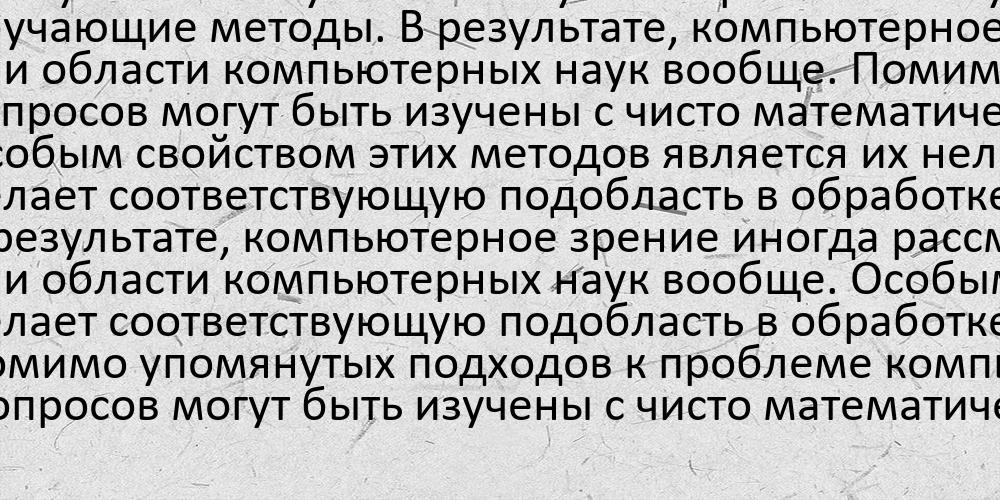

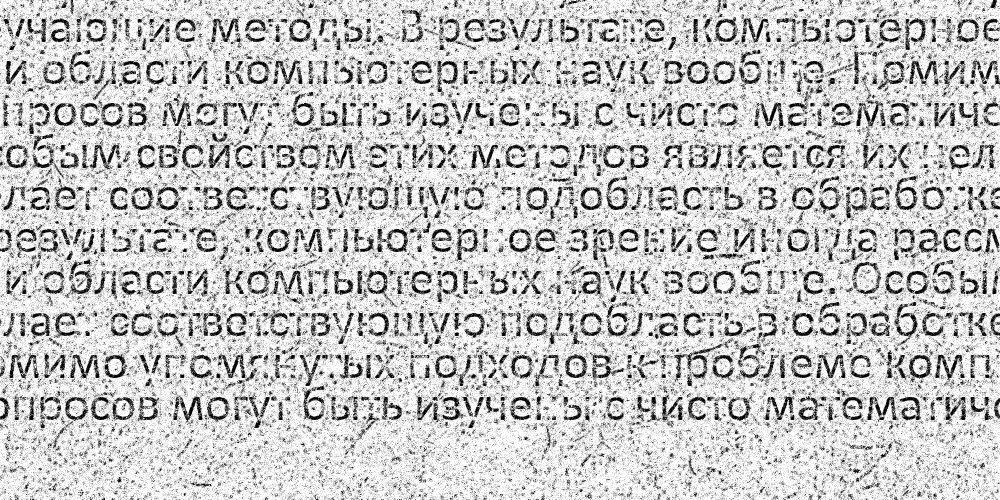

[INFO] processing /content/Denoise_document/dataset/test/image5.jpg


In [ ]:


# загрузим нашу модель (если до этого пропустили пункты выше)
# load our model (if you missed the points above before)
# model = pickle.loads(open(MODEL_PATH, "rb").read())

# получаем пути ко всем изображениям в каталоге тестирования
# перемешиваем их и берем только часть соответствующую размеру выборки 
# grab the paths to all images in the testing directory and then
# randomly sample them
imagePaths = list(paths.list_images(args["testing"]))
random.shuffle(imagePaths)
imagePaths = imagePaths[:args["sample"]]

# перебираем пути образцов изображения
# loop over the sampled image paths
for imagePath in imagePaths:
    # загружаем изображение, преобразовываем в градации серого и дублируем его
    # load the image, convert it to grayscale, and clone it
    print("[INFO] processing {}".format(imagePath))
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    orig = image.copy()

    # накладываем и размываем изображение
    # pad the image followed by blurring/thresholding it
    image = cv2.copyMakeBorder(image, 2, 2, 2, 2,
        cv2.BORDER_REPLICATE)
    image = blur_and_threshold(image)

    # инициализируем список для хранения ROI (областей размером 5x5)
    # initialize a list to store our ROI features (i.e., 5x5 pixel
    # neighborhoods)
    roiFeatures = []

    # "скользим" окном 5x5 по изображению, смещаясь по одному элементу 
    # slide a 5x5 window across the image
    for y in range(0, image.shape[0]):
        for x in range(0, image.shape[1]):
            # извлекаем ROI окна и получаем пространственные размеры
            # extract the window ROI and grab the spatial dimensions
            roi = image[y:y + 5, x:x + 5]
            (rH, rW) = roi.shape[:2]

            # если ROI не размера 5x5, то мы его не учитываем
            # if the ROI is not 5x5, throw it out
            if rW != 5 or rH != 5:
                continue

            # мы формируем необработанные данные в вектор, а в качестве 
            # целевого прогноза указываем центральный пиксель в окне 5x5
            #  очищенных изображений
            # our features will be the flattened 5x5=25 pixels from
            # the training ROI
            # возвращает копию массива сжатую до одного измерения 
            # returns a copy of the array compressed to one dimension
            features = roi.flatten() 
            roiFeatures.append(features)

    # предсказваем пискели для нашего нового изображения
    # use the ROI features to predict the pixels of our new denoised
    # image
    pixels = model.predict(roiFeatures)

    # пока что наши предсказания выглядят, как одномерный массив, 
    # поэтому нам необходимо его преобразовать в двухмерный и
    # масштабировать из диапазона [0, 1] в [0, 255]
    # the pixels list is currently a 1D array so we need to reshape
    # it to a 2D array (based on the original input image dimensions)
    # and then scale the pixels from the range [0, 1] to [0, 255]
    pixels = pixels.reshape(orig.shape)
    output = (pixels * 255).astype("uint8")

    # выводим первоначальное изображение и обработанное 
    # show the original and output images
    cv2_imshow(orig)
    cv2_imshow(output)
    cv2.waitKey(0)